# Analyse de sensibilité

In [1]:
from retraites.SimulateurRetraites import SimulateurRetraites
from retraites.ModelePensionProbabiliste import ModelePensionProbabiliste
import openturns as ot
import openturns.viewer as otv
import pylab as pl
import scipy as sp
import numpy as np

## Définition des paramètres

In [2]:
simulateur = SimulateurRetraites()

## Définition du modèle probabiliste

In [3]:
S = 0.0
D = 0.14
annee = 2070 # Année de calcul
modele = ModelePensionProbabiliste(simulateur, annee, S, D)

Nous souhaitons probabiliser les variables suivantes :
* As : l'âge de départ à la retraite de l'utilisateur
* E : coefficient d'élasticité (par défaut, E = 0.5)
* TauC : le taux de chômage

Les autres variables sont donc fixées à leur valeur de référence.

In [4]:
fonctionPension = modele.getFonction()

In [5]:
inputDistribution = modele.getInputDistribution()

## Analyse de sensibilité

In [6]:
size = 500
computeSecondOrder = False
sie = ot.SobolIndicesExperiment(inputDistribution, size, computeSecondOrder)
inputDesign = sie.generate()

In [7]:
outputDesign = fonctionPension(inputDesign)

In [8]:
sensitivityAnalysis = ot.SaltelliSensitivityAlgorithm(inputDesign, outputDesign, size)

In [9]:
sensitivityAnalysis.setUseAsymptoticDistribution(True)

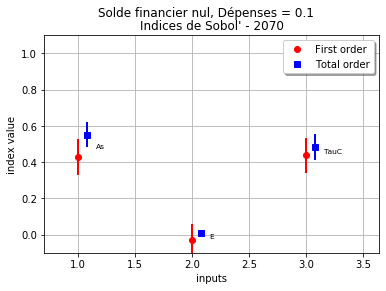

In [10]:
graph = sensitivityAnalysis.draw()
view = otv.View(graph)
pl.suptitle("Solde financier nul, Dépenses = %.1f" % (D));
pl.title("Indices de Sobol' - %d" % (annee));

## Indices de Sobol' en fonction de l'année

In [11]:
def calculeIndicesSobol(annee, S, D, size = 1000):
    """
    Calcule les indices de Sobol' pour une année donnée.
    
    Paramètres
    annee : un float, l'année
    S : le solde financier
    D : les dépenses de retraite (% PIB)
    sensitivityAnalysis : l'analyse de sensibilité
    
    """
    # Crée le modèle
    modele = ModelePensionProbabiliste(simulateur, annee, S, D)
    fonctionPension = modele.getFonction()
    inputDistribution = modele.getInputDistribution()
    # Calcule les indices de Sobol'
    computeSecondOrder = False
    sie = ot.SobolIndicesExperiment(inputDistribution, size, computeSecondOrder)
    inputDesign = sie.generate()
    outputDesign = fonctionPension(inputDesign)
    sensitivityAnalysis = ot.SaltelliSensitivityAlgorithm(inputDesign, outputDesign, size)
    return sensitivityAnalysis

In [12]:
table_annees = ot.Sample(range(2020,2071,5),1)
nbAnnees = len(table_annees)
firstOrderIndices = ot.Sample(nbAnnees,3)
firstOrderIndicesUpper = ot.Sample(nbAnnees,3)
firstOrderIndicesLower = ot.Sample(nbAnnees,3)
totalOrderIndices = ot.Sample(nbAnnees,3)
totalOrderIndicesUpper = ot.Sample(nbAnnees,3)
totalOrderIndicesLower = ot.Sample(nbAnnees,3)
S = 0.0
D = 0.14
for i in range(nbAnnees):
    a = table_annees[i,0]
    print(a)
    sensitivityAnalysis = calculeIndicesSobol(a, S, D)
    firstOrderIndices[i] = sensitivityAnalysis.getFirstOrderIndices()
    totalOrderIndices[i] = sensitivityAnalysis.getTotalOrderIndices()
    interval = sensitivityAnalysis.getFirstOrderIndicesInterval()
    firstOrderIndicesUpper[i] = interval.getUpperBound()
    firstOrderIndicesLower[i] = interval.getLowerBound()
    interval = sensitivityAnalysis.getTotalOrderIndicesInterval()
    totalOrderIndicesUpper[i] = interval.getUpperBound()
    totalOrderIndicesLower[i] = interval.getLowerBound()

2020.0
2025.0
2030.0
2035.0
2040.0
2045.0
2050.0
2055.0
2060.0
2065.0
2070.0


In [13]:
def setGraphBoundingBox(graph, xmin = None, xmax = None, ymin = None, ymax = None):
    """
    Set the bounding box in a graph with keywords.
    
    Parameters
    xmin : the x minimum value
    xmax : the x maximum value
    ymin : the y minimum value
    ymax : the y maximum value
    """
    boundingBox = graph.getBoundingBox()
    lb = boundingBox.getLowerBound()
    ub = boundingBox.getUpperBound()
    if xmin is not None:
        lb[0] = xmin
    if ymin is not None:
        lb[1] = ymin
    if xmax is not None:
        ub[0] = xmax
    if ymax is not None:
        ub[1] = ymax
    boundingBox.setLowerBound(lb)
    boundingBox.setUpperBound(ub)
    graph.setBoundingBox(boundingBox)
    return graph

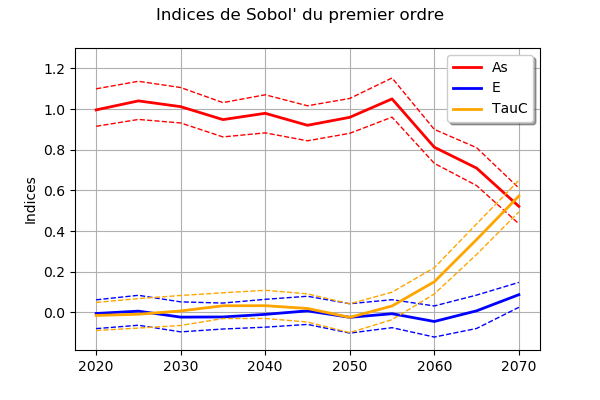

In [14]:
title = "Indices de Sobol' du premier ordre"
xTitle = ""
yTitle = "Indices" 
showAxes = True
descriptions = inputDistribution.getDescription()
dim = inputDistribution.getDimension()
colors = ["red", "blue", "orange"]
graph = ot.Graph(title, xTitle, yTitle, showAxes)
for i in range(dim):
    curve = ot.Curve(table_annees, firstOrderIndices[:,i])
    curve.setColor(colors[i])
    curve.setLegend(descriptions[i])
    curve.setLineWidth(2)
    graph.add(curve)
    curve = ot.Curve(table_annees, firstOrderIndicesUpper[:,i])
    curve.setColor(colors[i])
    curve.setLineStyle("dashed")
    graph.add(curve)
    curve = ot.Curve(table_annees, firstOrderIndicesLower[:,i])
    curve.setColor(colors[i])
    curve.setLineStyle("dashed")
    graph.add(curve)
graph.setLegendPosition("topright")
graph = setGraphBoundingBox(graph, ymax = 1.3)
graph

Le graphique précédent représente la sensibilité du modèle aux trois variables probabilisées. Les lignes continues représentent les indices de sensibilité tandis que les lignes discontinues représentent l'intervalle de confiance. 

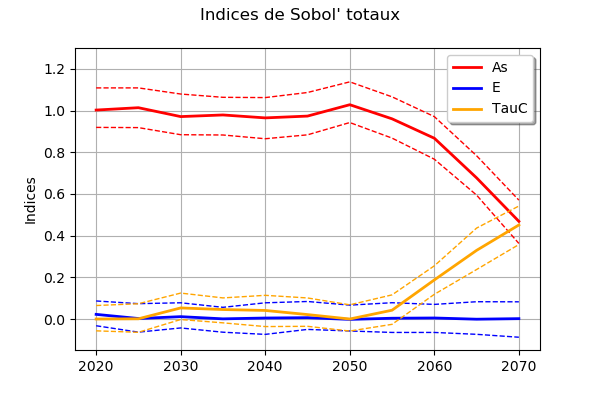

In [15]:
title = "Indices de Sobol' totaux"
xTitle = ""
yTitle = "Indices" 
showAxes = True
descriptions = inputDistribution.getDescription()
dim = inputDistribution.getDimension()
colors = ["red", "blue", "orange"]
graph = ot.Graph(title, xTitle, yTitle, showAxes)
for i in range(dim):
    curve = ot.Curve(table_annees, totalOrderIndices[:,i])
    curve.setColor(colors[i])
    curve.setLegend(descriptions[i])
    curve.setLineWidth(2)
    graph.add(curve)
    curve = ot.Curve(table_annees, totalOrderIndicesUpper[:,i])
    curve.setColor(colors[i])
    curve.setLineStyle("dashed")
    graph.add(curve)
    curve = ot.Curve(table_annees, totalOrderIndicesLower[:,i])
    curve.setColor(colors[i])
    curve.setLineStyle("dashed")
    graph.add(curve)
graph.setLegendPosition("topright")
graph = setGraphBoundingBox(graph, ymax = 1.3)
graph